In [1]:
# autoreload modules
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from b2aiprep.dataset import VBAIDataset

We have reformatted the data into a [BIDS](https://bids-standard.github.io/bids-starter-kit/folders_and_files/folders.html)-like format. The data is stored in a directory with the following structure:

```
data/
    sub-01/
        ses-01/
            beh/
                sub-01_ses-01_questionnaire.json
    sub-02/
        ses-01/
            beh/
                sub-01_ses-01_questionnaire.json
    ...
```

i.e. the data reflects a subject-session-datatype hierarchy. The `beh` subfolder, for behavioural data, was chosen to store questionnaire data as it is the closest approximation to the data collected.

We have provided utilities which load in data from the BIDS-like dataset structure. The only input needed is the folder path which stores the data.

In [14]:
# TODO: allow user to specify input folder input
dataset = VBAIDataset('/Users/isaacbevers/sensein/b2ai-wrapper/b2ai-data-bids-like')

In [15]:
# every user has a sessionschema which we can get info for the users from
qs = dataset.load_questionnaires('sessionschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    # get the dataframe for this questionnaire
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1

# concatenate all the dataframes
sessionschema_df = pd.concat(q_dfs)
sessionschema_df = pd.pivot(sessionschema_df, index='dataframe_number', columns='linkId', values='valueString')
sessionschema_df

linkId,record_id,session_duration,session_id,session_is_control_participant,session_site,session_status
dataframe_number,,,,,,
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,2835.0,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,No,Mt. Sinai,Completed
1,7f10bd3f-cbf9-4875-9716-308af292d058,4671.0,5FA011D3-8426-481D-86D6-A3D69B9879B3,No,USF,Completed
2,49d831ec-f348-43de-8202-15f659196b02,2258.0,A69B9A56-359D-4035-82F0-39BC536AE509,Yes,VUMC,Completed
3,4464b02f-bee1-4b72-84e5-55700c8bbc67,2826.0,AD71D502-11D0-4FF2-B88B-10BA2D86EC28,No,Mt. Sinai,Completed
4,b1fe4758-940f-4ffc-8ad2-2c1054f14e95,3743.0,4DA3268C-BC66-46E6-B254-24B13C563625,No,MIT,Completed
...,...,...,...,...,...,...
192,b1b4b453-42c9-4053-9367-bfc2baac38bf,3157.0,7C36DA1B-17A9-41FD-98CA-26792B900CD0,No,USF,Completed
193,7afccc36-c15f-46ae-8d1b-db15d4e6b7b9,2365.0,B5B5E02F-1B56-4793-A70C-5B3BEDFAAA69,No,MIT,Completed
194,2e59cc45-df19-4e2d-a1d8-60c46cf47a63,1828.0,B0F79E3A-0B91-43E2-920D-75AB5063FD6E,Yes,USF,Completed


The above session schema gives us some information about each "session" which occurred for each participant. In this context, a session is a clinical encounter where the participant answers a number of questions and has a number of audio recordings taken. The above dataframe has

- `record_id` - a unique identifier for the individual
- `session_duration` - the length in seconds of the session
- `session_id` - a unique identifier for the session
- `session_is_control_participant` - "Yes" or "No" indicating whether the participant is a control
- `session_site` - The site of data collection: one of "Mt. Sinai", "VUMC", "USF", "WCM", or "MIT"
- `session_status` - This indicates if the session was completed. Since we are using the deidentified release data, every row should be "Completed".

Note what happened in the above cell to get us this `sessionschema_df` dataframe:

1. We determined the name of the QuestionnaireResponse that we wanted to load in. In this case it was `'sessionschema'`.
2. We called `load_questionnaires(questionnare_name)` with the name of the questionnaire. This function returned a dictionary: the keys are the participant identifiers (`record_id`), and the values were a set of `QuestionnaireResponse` objects which matched the questionnaire name.
3. We then iterated through each participant's `QuestionnaireResponse` objects and converted them to pandas dataframes using `questionnaire_to_dataframe()`.
4. We concatenated the resultant dataframes together.
5. The concatenated dataframe was in "long" form, with three columns: the participant identifier (`record_id`), a unique identifier for each question (`linkId`), and the response given (`valueString`). We used `pd.pivot()` in order to transform this into a "wide" dataframe, with one column per question.

The above process is involved, but consistent across questionnaires. For convenience, the `load_and_pivot_questionnaire` helper function automatically performs these tasks for a given questionnaire. Let's try it with the demographics dataframe.

In [16]:
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema')
demographics_df.head()

linkId,record_id,demographics_session_id,demographics_duration,demographics_completed_by___1,demographics_completed_by___2,demographics_completed_by___3,state_province,country,gender_identity,specify_gender_identity,...,household_count,spouse_partner_sig_other,children,parent,grandparent,other_live_with,others_household_specify,transportation_yn,primary_transportation,q_generic_demographics_complete
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,276.0,True,False,False,ON,Canada,Male gender identity,Cis: same gender as the sex assigned at birth,...,5.0,No,Yes,No,No,No,NaN,Yes,NaN,Complete
1,7f10bd3f-cbf9-4875-9716-308af292d058,5FA011D3-8426-481D-86D6-A3D69B9879B3,218.0,True,False,True,FL,USA,Male gender identity,Cis: same gender as the sex assigned at birth,...,3.0,Yes,No,No,No,No,NaN,Yes,NaN,Complete
2,49d831ec-f348-43de-8202-15f659196b02,A69B9A56-359D-4035-82F0-39BC536AE509,179.0,True,False,False,Nashville,USA,Male gender identity,Cis: same gender as the sex assigned at birth,...,1.0,No,No,No,No,No,NaN,Yes,NaN,Complete
3,4464b02f-bee1-4b72-84e5-55700c8bbc67,AD71D502-11D0-4FF2-B88B-10BA2D86EC28,222.0,True,False,False,ON,Canada,Male gender identity,Cis: same gender as the sex assigned at birth,...,2.0,Yes,No,No,No,No,NaN,Yes,NaN,Complete
4,b1fe4758-940f-4ffc-8ad2-2c1054f14e95,4DA3268C-BC66-46E6-B254-24B13C563625,211.0,True,False,False,MA,USA,Male gender identity,Cis: same gender as the sex assigned at birth,...,1.0,No,No,No,No,No,NaN,No,NaN,Complete


We can iterate through a couple of columns and summarize the data.

In [17]:
for column in ['children', 'country', 'ethnicity', 'gender_identity', 'grandparent', 'housing_status']:
    print(demographics_df[column].value_counts(), end='\n\n')

children
No     146
Yes     28
Name: count, dtype: int64

country
USA       160
Canada     14
Name: count, dtype: int64

ethnicity
Not Hispanic or Latino    146
Hispanic or Latino         18
Prefer not to answer       10
Name: count, dtype: int64

gender_identity
Female gender identity                       107
Male gender identity                          62
Non-binary or genderqueer gender identity      5
Name: count, dtype: int64

grandparent
No    174
Name: count, dtype: int64

housing_status
Own home                                 109
Rent home                                 43
Skilled nursing facility/nursing home      2
Assisted living                            1
Unhoused-permanently                       1
Name: count, dtype: int64



## Finding data

The dataset functions are convenient, but they require some prior knowledge: we needed to know that `sessionschema` was the name for the questionnaire with session information. We also needed to know that `demographics` was the name for the questionnaire where general demographics were collected. For convenience, the dataset object has another method which tells you all of the questionnaire names available. It accomplishes this by iterating through every file of the BIDS dataset. Note that this can be an expensive operation! Luckily, if there are less than 10,000 files, it goes pretty fast. Let's try it out.

In [18]:
questionnaire_types = dataset.list_questionnaire_types()
for q in questionnaire_types:
    print(q)

acoustictaskschema
airwaystenosis
als
alzheimers
benignLesion
bipolar
depression
eligibility
enrollment
laryngealCancer
laryngealDystonia
parkinsons
participant
precancerousLesions
qgenericconfoundersschema
qgenericdemographicsschema
qgenericgad7anxietyschema
qgenericpatienthealthquestionnaire9schema
qgenericvoicehandicapindexvhi10schema
qgenericvoiceperceptionschema
qmoodadhdadultschema
qmoodcustomaffectscaleschema
qmooddsm5adultschema
qmoodpanasschema
qmoodptsdadultschema
qneuroproductivevocabularyschema
qneurorandomitemgenerationschema
qneurowinogradschemasschema
qneurowordcolorstroopschema
qrespdyspneaindexdischema
qrespleicestercoughquestionnairelcqschema
qvoicevoiceproblemseverityschema
recordingschema
vocalFoldParalysis


The above lists out the possible inputs to questionnaire types. Note that some questionnaires are only asked once per subject, such as eligibility. We can limit our list to only these questionnaires:

In [19]:
questionnaire_types = dataset.list_questionnaire_types(subject_only=True)
for q in questionnaire_types:
    print(q)

airwaystenosis
als
alzheimers
benignLesion
bipolar
depression
eligibility
enrollment
laryngealCancer
laryngealDystonia
parkinsons
participant
precancerousLesions
vocalFoldParalysis


Above we see that `eligibility`, `enrollment`, `participant` and a number of disease specific questionnaires are only ever asked once for the participant. As before, we can use `load_and_pivot_questionnaire()` to load in this data into a convenient to use dataframe.

In [22]:
eligibility_df = dataset.load_and_pivot_questionnaire('eligibility')
eligibility_df.head()

linkId,record_id,eligible_studies___1,eligible_studies___2,eligible_studies___3,eligible_studies___4,eligible_studies___5,is_control_participant,laryng_cancer,benign_cord_lesion,rrp,...,panic,ptsd,schizophrenia,soc_anx_dis,other_psych,asthma,airway_stenosis,chronic_cough,copd,osa
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,False,True,False,False,False,No,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7f10bd3f-cbf9-4875-9716-308af292d058,False,True,False,True,False,No,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,49d831ec-f348-43de-8202-15f659196b02,True,True,True,True,False,Yes,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4464b02f-bee1-4b72-84e5-55700c8bbc67,False,True,False,False,False,No,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,b1fe4758-940f-4ffc-8ad2-2c1054f14e95,False,False,True,False,False,No,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Participants dataframe

We can get a dataframe summarizing the participants in the dataset.

In [23]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
participant_df.head()

linkId,record_id,selected_language,enrollment_institution,age,eligible_studies___1,eligible_studies___2,eligible_studies___3,eligible_studies___4,eligible_studies___5,is_control_participant,...,diagnosis_als_treatment_and_management_yes_medications___tofersen,diagnosis_als_treatment_and_management_yes_medications___symptomatic_treatment,diagnosis_als_treatment_and_management_yes_medications___other,diagnosis_als_treatment_and_management_yes_supportive_care___physical_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___occupational_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___speech_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___respiratory_support,diagnosis_als_treatment_and_management_yes_supportive_care___nutrition_support,diagnosis_als_treatment_and_management_yes_supportive_care___psychotherapy,diagnosis_als_treatment_and_management_yes_supportive_care___other
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,English,Mt. Sinai,79.0,False,True,False,False,False,No,...,False,False,False,False,False,False,False,False,False,False
1,7f10bd3f-cbf9-4875-9716-308af292d058,English,USF,71.0,False,True,False,True,False,No,...,False,False,False,False,False,False,False,False,False,False
2,49d831ec-f348-43de-8202-15f659196b02,English,VUMC,36.0,True,True,True,True,False,Yes,...,False,False,False,False,False,False,False,False,False,False
3,4464b02f-bee1-4b72-84e5-55700c8bbc67,English,Mt. Sinai,84.0,False,True,False,False,False,No,...,False,False,False,False,False,False,False,False,False,False
4,b1fe4758-940f-4ffc-8ad2-2c1054f14e95,English,MIT,54.0,False,False,True,False,False,No,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# bar chart of participant by enrollment institution
plt.figure(figsize=(10, 5))
participant_df['enrollment_institution'].value_counts().plot(kind='bar')
plt.show()

## Session data

Load in the `QuestionnaireResponse` objects for the session schema.

In [ ]:
session_schema = dataset.load_questionnaires('sessionschema')

# Each element is a QuestionnaireResponse, a pydantic object
# you can serialize it to a python dictionary with .dict()
# and to a json with .json()
# otherwise attributes are accessible like any other python object
questionnaire = session_schema[0]

print(f'FHIR ID: {questionnaire.id}')
print(f'First item response: {questionnaire.item[0]}')
print('\nAbridged questionnaire as JSON:')
# only print the first 600 characters of the JSON for brevity
print(questionnaire.json(indent=2)[:660], end='\n...\n')

In [ ]:
# helper function which loads in questionnaires ending with a specific schema name as a dataframe
session_df = dataset.load_and_pivot_questionnaire('sessionschema')
session_df.head()

We can look at a specific questionnaire which is collected for each session in a similar way.

In [ ]:
session_confounders = dataset.load_questionnaires('qgenericconfoundersschema')
questionnaire = session_confounders[0]

# Each element is a QuestionnaireResponse, a pydantic object
# you can serialize it to a python dictionary with .dict()
# and to a json with .json()
# otherwise attributes are accessible like any other python object
print(questionnaire.json(indent=2))

## Acoustic tasks

Let's look at the acoustic tasks now. Acoustic task files are organized in the following way:

```
data/
    sub-01/
        ses-01/
            beh/
                sub-01_ses-01_task-<TaskName>_acoustictaskschema.json
                sub-01_ses-01_task-<TaskName>_rec-<TaskName>-1_recordingschema.json
                ...
```

where `TaskName` is the name of the acoustic task, including:

* `Audio-Check`
* `Cinderalla-Story`
* `Rainbow-Passage`

etc. The audio tasks are listed currently in b2aiprep/prepare.py:_AUDIO_TASKS.

In [ ]:
acoustic_tasks = dataset.load_questionnaires('acoustictaskschema')
print(acoustic_tasks[0].json(indent=2))

Each row in the above corresponds to a different acoustic task: an audio check, prolonged vowels, etc. The `value_counts()` method for pandas DataFrames lets us count all the unique values for a column.

In [ ]:
acoustic_tasks_df = dataset.load_and_pivot_questionnaire('acoustictaskschema')
acoustic_tasks_df.head()

Above will list out all of the acoustic tasks, as every acoustic task is associated with a single "acoustictaskschema" `QuestionnaireResponse` object.

In [ ]:
acoustic_tasks_df['acoustic_task_name'].value_counts()

## Audio

In [8]:
import numpy as np
from senselab.audio.tasks.preprocessing.preprocessing import resample_audios
from senselab.audio.data_structures.audio import Audio
import IPython.display as Ipd

# configuration options
win_length = 512
hop_length = 256

base_path = 'b2aiprep/data/test_audio.wav'
audio = Audio.from_filepath(base_path)
audio = resample_audios([audio], resample_rate=16000)[0]

# convert to uint32 - probably should use the bits_per_sample from the original metadata!
signal = audio.waveform.squeeze()
signal = (np.iinfo(np.uint32).max * (signal - signal.min())) / (signal.max() - signal.min())

# display a widget to play the audio file
Ipd.display(Ipd.Audio(data=signal, rate=audio.sampling_rate))

We can also calculate a spectrogram of the data to visualize the frequency components over time. A spectrogram is essentially a frequency spectrum repeated `N` times spaced out throughout the original audio.

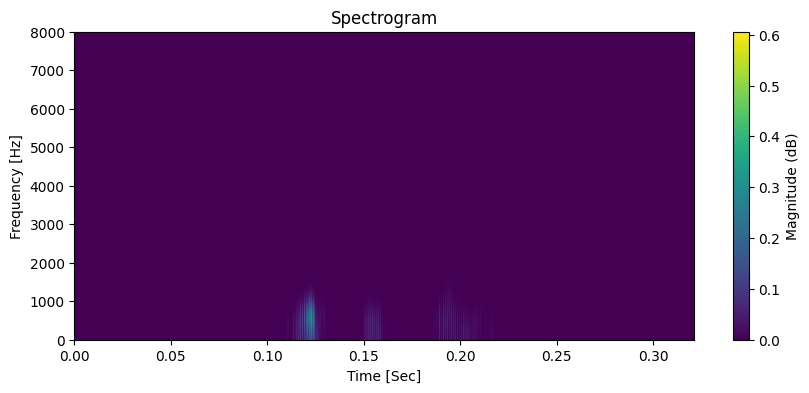

In [15]:
from senselab.audio.tasks.features_extraction.torchaudio import extract_spectrogram_from_audios
from senselab.audio.tasks.plotting.plotting import plot_specgram
win_length = 30
hop_length = 10
nfft = 512
features_specgram = extract_spectrogram_from_audios([audio], win_length=win_length, hop_length=hop_length, n_fft=nfft)[0]["spectrogram"]
plot_specgram(features_specgram, audio.sampling_rate)